In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import shap
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
import torch

In [2]:
torch.manual_seed(42)
np.random.seed(42)

data_path = 'Downloads/data_tep/'


def load_data(file_path):
    data = pd.read_csv(file_path, index_col=0)  
    
    if 'Fault' in data.columns:
        data = data.drop('Fault', axis=1)
    
    return data.values

def create_dataset():
    X = []
    y = []
    
    for i in range(21):  
        train_file = os.path.join(data_path, f'{i}.csv')  
        train_data = load_data(train_file)
        
        if i == 0:
            X.append(train_data)
            y.append(np.zeros(train_data.shape[0]))
        else:
            X.append(train_data)
            labels = np.zeros(train_data.shape[0])
            labels[20:] = 1  
            y.append(labels)
    
    for i in range(21):  
        test_file = os.path.join(data_path, f'{i}_te.csv')  
        test_data = load_data(test_file)
        
        if i == 0:
            X.append(test_data)
            y.append(np.zeros(test_data.shape[0]))
        else:
            X.append(test_data)
            y.append(np.ones(test_data.shape[0])) 
    
    X = np.vstack(X)
    y = np.concatenate(y)
    
    return X, y

def create_separate_datasets():
    """
    Function that keeps train and test sets separate
    """
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    
    for i in range(21):
        train_file = os.path.join(data_path, f'd{i:02d}.csv')  
        train_data = load_data(train_file)
        
        if i == 0:
            X_train.append(train_data)
            y_train.append(np.zeros(train_data.shape[0]))
        else:
            X_train.append(train_data)
            labels = np.zeros(train_data.shape[0])
            labels[20:] = 1
            y_train.append(labels)
    
    for i in range(21):
        test_file = os.path.join(data_path, f'd{i:02d}_te.csv')  
        test_data = load_data(test_file)
        
        if i == 0:
            X_test.append(test_data)
            y_test.append(np.zeros(test_data.shape[0]))
        else:
            X_test.append(test_data)
            y_test.append(np.ones(test_data.shape[0]))
    
    return (np.vstack(X_train), np.concatenate(y_train), 
            np.vstack(X_test), np.concatenate(y_test))

In [3]:
def analyze_feature_importance_shap_mlp(X_train, X_test, y_train, y_test, feature_names=None):
    """
    Analyze feature importance using SHAP values with MLPClassifier, including balancing and CV
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    le = LabelEncoder()
    y_train_int = le.fit_transform(y_train)
    y_test_int = le.transform(y_test)
    
    n_features = X_train.shape[1]
    if feature_names is None or len(feature_names) != n_features:
        feature_names = [f'Variable_{i}' for i in range(n_features)]
    
    X_train_df = pd.DataFrame(X_train_scaled, columns=feature_names)
    X_test_df = pd.DataFrame(X_test_scaled, columns=feature_names)
    
    sampling_pipeline = Pipeline([
        ('smote', SMOTE(sampling_strategy=0.8, random_state=42)),  
        ('undersampler', RandomUnderSampler(sampling_strategy=0.9, random_state=42))  
    ])
    
    print("\nResampling the dataset for better class balance...")
    X_train_resampled, y_train_resampled = sampling_pipeline.fit_resample(X_train_scaled, y_train_int)
    print(f"Original dataset shape: {np.bincount(y_train_int)}")
    print(f"Resampled dataset shape: {np.bincount(y_train_resampled)}")
    
    param_distributions = {
    'hidden_layer_sizes': [(300,150,75), (250,125,60), (200,150,100,50)],
    'activation': ['relu', 'tanh'],
    'learning_rate_init': [0.005, 0.001, 0.0005],
    'alpha': [0.0001, 0.001],
    'batch_size': [64, 128]
    }

    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_int), y=y_train_int)
    class_weight_dict = dict(zip(np.unique(y_train_int), class_weights))
    
    base_mlp = MLPClassifier(
    hidden_layer_sizes=(200, 150, 100, 50),
    activation='relu',
    solver='adam',
    alpha=0.001,
    batch_size=128,
    learning_rate='adaptive',  
    learning_rate_init=0.001,
    max_iter=2000,
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=10,
    random_state=42,
    power_t=0.5
    )
    
    print("\nPerforming RandomizedSearchCV...")
    random_search = RandomizedSearchCV(
        base_mlp,
        param_distributions=param_distributions,
        n_iter=20,
        cv=5,
        scoring='f1_macro',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    random_search.fit(X_train_resampled, y_train_resampled)
    
    print("\nBest parameters found:")
    for param, value in random_search.best_params_.items():
        print(f"{param}: {value}")
    print(f"Best cross-validation score: {random_search.best_score_:.3f}")
    
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    
    print("\nModel Performance:")
    print(classification_report(y_test_int, y_pred))
    
    cm = confusion_matrix(y_test_int, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    sample_size = min(100, X_train_resampled.shape[0])
    background = shap.kmeans(X_train_df.sample(sample_size, random_state=42), 10)
    
    def predict_proba_class1(X):
        return best_model.predict_proba(X)[:, 1]
    
    explainer = shap.KernelExplainer(predict_proba_class1, background)
    
    n_samples = min(100, X_test_df.shape[0])
    test_sample = X_test_df.sample(n_samples, random_state=42)
    shap_values = explainer.shap_values(test_sample)
    
    if shap_values.ndim > 2:
        shap_values = shap_values.reshape(shap_values.shape[0], -1)
    
    mean_shap = np.abs(shap_values).mean(axis=0)
    
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': mean_shap
    })
    
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    
    total_importance = feature_importance['Importance'].sum()
    feature_importance['Percentage'] = (feature_importance['Importance'] / total_importance * 100).round(2)
    
    plt.figure(figsize=(12, 6))
    plt.barh(feature_importance['Feature'][:10], feature_importance['Percentage'][:10])
    plt.xlabel('Importance (%)')
    plt.ylabel('Features')
    plt.title('Top 10 Most Important Features')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        shap_values,
        test_sample,
        plot_type="violin",
        max_display=10,  
        show=False  
    )
    plt.title('SHAP Values Distribution')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        shap_values,
        test_sample,
        plot_type="bar",  
        max_display=10,
        show=False
    )
    plt.title('SHAP Feature Importance')
    plt.tight_layout()
    plt.show()

    
    return feature_importance, shap_values, explainer, best_model

def create_feature_names(n_features):
    feature_names = []
    for i in range(n_features):
        if i < 41:  
            feature_names.append(f'XMEAS({i+1})')
        else:  
            feature_names.append(f'XMV({i-40})')
    return feature_names



Resampling the dataset for better class balance...
Original dataset shape: [ 900 9600]
Resampled dataset shape: [7680 8533]

Performing RandomizedSearchCV...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best parameters found:
learning_rate_init: 0.001
hidden_layer_sizes: (200, 150, 100, 50)
batch_size: 128
alpha: 0.001
activation: relu
Best cross-validation score: 0.912

Model Performance:
              precision    recall  f1-score   support

           0       0.10      0.21      0.13       160
           1       0.96      0.90      0.93      3200

    accuracy                           0.87      3360
   macro avg       0.53      0.56      0.53      3360
weighted avg       0.92      0.87      0.89      3360



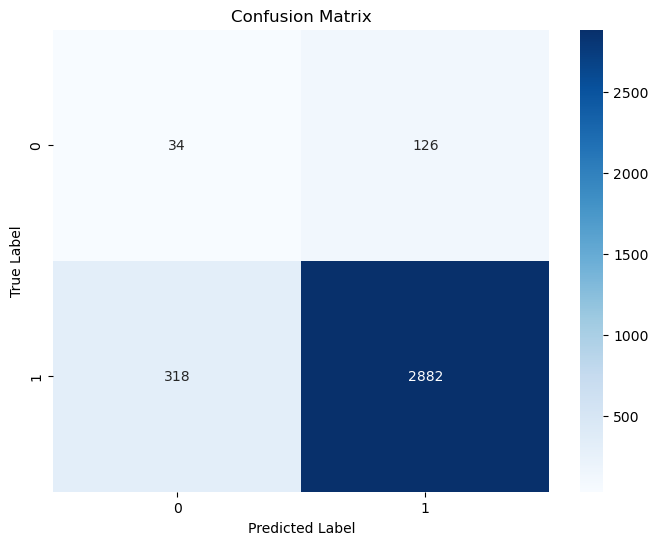

  0%|          | 0/100 [00:00<?, ?it/s]

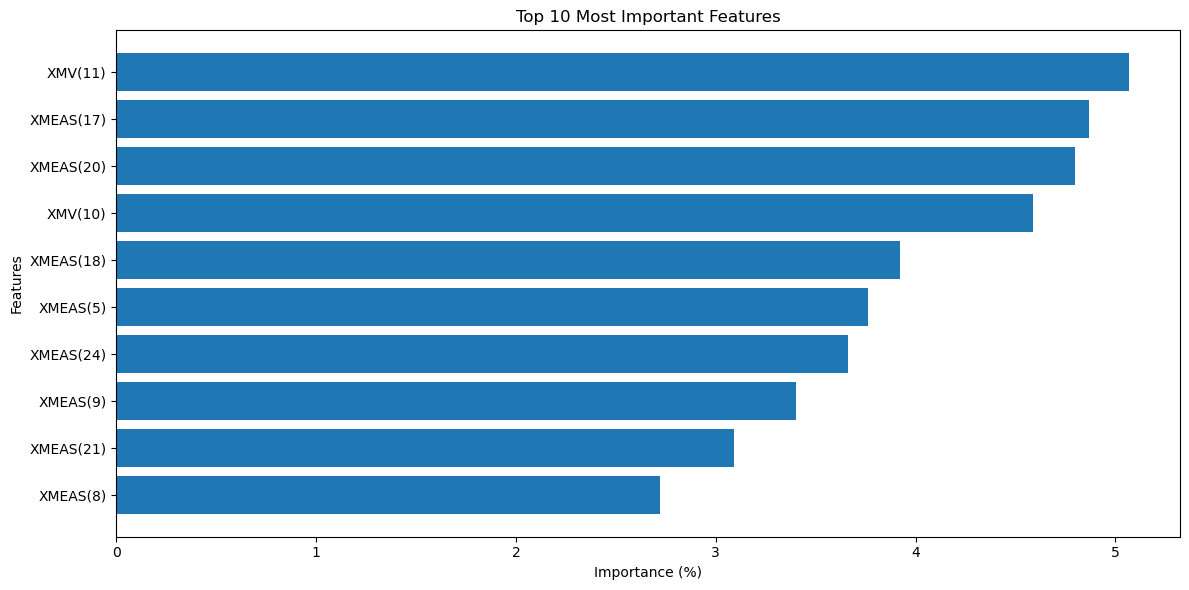

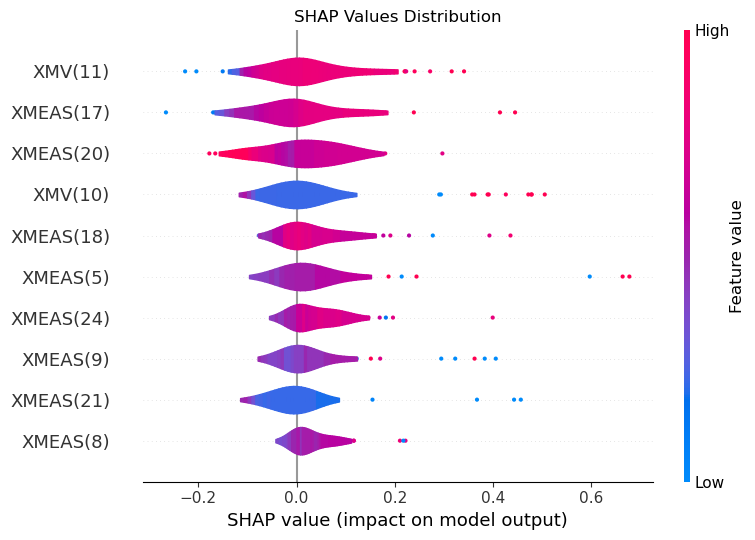

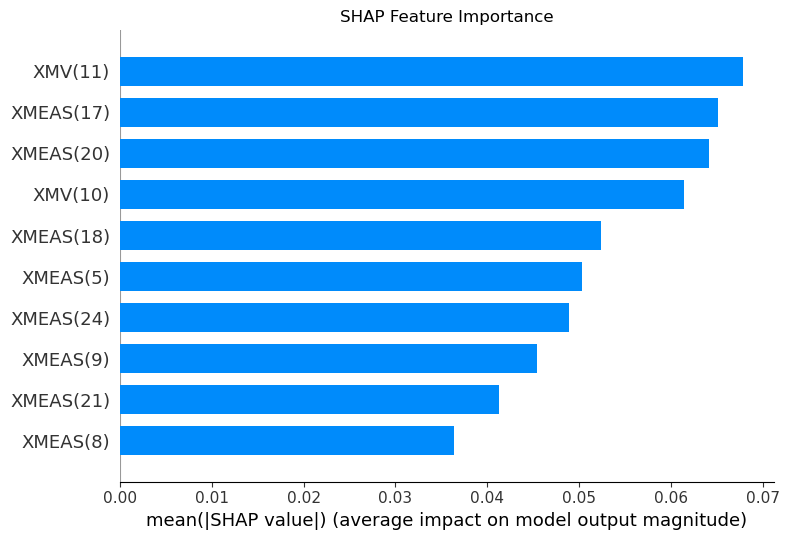


Top 20 Most Important Features:
      Feature  Importance  Percentage
51    XMV(11)       0.068       5.070
16  XMEAS(17)       0.065       4.870
19  XMEAS(20)       0.064       4.800
50    XMV(10)       0.061       4.590
17  XMEAS(18)       0.052       3.920
4    XMEAS(5)       0.050       3.760
23  XMEAS(24)       0.049       3.660
8    XMEAS(9)       0.045       3.400
20  XMEAS(21)       0.041       3.090
7    XMEAS(8)       0.036       2.720
38  XMEAS(39)       0.035       2.580
0    XMEAS(1)       0.030       2.210
36  XMEAS(37)       0.030       2.210
5    XMEAS(6)       0.029       2.180
13  XMEAS(14)       0.029       2.140
3    XMEAS(4)       0.025       1.900
37  XMEAS(38)       0.025       1.880
10  XMEAS(11)       0.025       1.870
40  XMEAS(41)       0.025       1.870
2    XMEAS(3)       0.025       1.860


In [4]:
if __name__ == "__main__":
    X_train, y_train, X_test, y_test = create_separate_datasets()
    
    feature_names = create_feature_names(X_train.shape[1])
    
    importance_df, shap_values, explainer, best_model = analyze_feature_importance_shap_mlp(
        X_train, X_test, y_train, y_test, feature_names
    )
    
    print("\nTop 20 Most Important Features:")
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    print(importance_df.head(20))